In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.utils import shuffle

In [53]:
# Input Folders
main_folder = 'dataset/traffic_object_detection'
train_folder = f'{main_folder}/train'
test_folder = f'{main_folder}/test'
valid_folder = f'{main_folder}/valid'

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = [[0, 0, 255], [255, 0, 0], [0, 255, 0], [200, 200, 0], [200, 200, 200]]

In [68]:
def upscale_points(image, coordinates, startFromZero= False):
    if startFromZero:
        x = int(coordinates[0] * image.shape[0])
        y = int(coordinates[1] * image.shape[1])
        width = int(coordinates[2] * image.shape[0])
        height = int(coordinates[3] * image.shape[1])
        return (y, x, height, width)
    else:
        x = int(coordinates[1] * image.shape[0])
        y = int(coordinates[2] * image.shape[1])
        width = int(coordinates[3] * image.shape[0])
        height = int(coordinates[4] * image.shape[1])
        return (int(coordinates[0]), y, x, height, width)

def draw_boundary(image, color, coordinates, startFromZero= False, upScale= True):
    if upScale:
        if startFromZero:
            (x, y, width, height) = upscale_points(image, coordinates, startFromZero)
        else:
            (object_class, x, y, width, height) = upscale_points(image, coordinates, startFromZero)
    else:
        if startFromZero:
            x, y, width, height = coordinates
        else:
            object_class, x, y, width, height =  coordinates
    image[x-width:x+width, y-height:y-height+5, :] = color
    image[x+width:x+width+5, y-height:y+height, :] = color
    image[x-width:x+width, y+height-5:y+height, :] = color
    image[x-width-5:x-width, y-height:y+height, :] = color
    if startFromZero:
        return image
    else:
        return image, (int(coordinates[0]), x, y, width, height)

def clip(value, prev_min, prev_max, new_min, new_max):
    return int((((value - prev_min) * (new_max - new_min)) / (prev_max - prev_min)) + new_min)

def load_image(folder, images_list, labels_list, index):
    image = plt.imread(f'{folder}/images/{images_list[index]}')
    image = cv2.resize(image, (640, 640))
    object_coordinates = []
    with open(f'{folder}/labels/{labels_list[index]}', 'r') as file:
        label = file.readlines()
    for lab in label:
        coordinates = [float(num) for num in lab.split(' ')]
        coords = upscale_points(image, coordinates)
        object_coordinates.append(coords)
    return image, object_coordinates

# Generates anchor points accross the image
def generate_anchor_points(image, stride = 5):
    anchor_points = []
    for i in range(stride, image.shape[0], stride):
        for j in range(stride, image.shape[1], stride):
            anchor_points.append([i, j])
    return anchor_points

def generate_regions(anchor_points, region_ratios, region_scales):
    # Going for each anchor point
    regions = []
    for anchor in anchor_points:
        for ratio in region_ratios:
            for scale in region_scales:
                value = 1 * scale
                width = ratio[0] * value
                height = ratio[1] * value
                regions.append([anchor[0], anchor[1], width, height])
    return regions

def overlapArea(rect1, rect2):

   # Finding the length and width of the overlap area
   x = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]))
   y = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]))
   area = x * y
   return area


# Checks whether the region goes out of the iamge at any side or not
def is_region_inside_image(image, x, y, width, height):
    if x - width < 0 or x + width > image.shape[0] or y - height < 0 or y + height > image.shape[1]:
        return False
    else:
        return True

def find_IOU(object_coords, target_region):
    a1 = (object_coords[3] * 2) * (object_coords[4] * 2)
    a2 = (target_region[2] * 2) * (target_region[3] * 2)
    rect1 = [object_coords[1] - object_coords[3], object_coords[2] - object_coords[4], object_coords[1] + object_coords[3], object_coords[2] + object_coords[4]]
    rect2 = [target_region[0] - target_region[2], target_region[1] - target_region[3], target_region[0] + target_region[2], target_region[1] + target_region[3]]
    intersection_area = overlapArea(rect1, rect2)
    # intersection_area = intersection[0] * intersection[1]
    total_area = a1 + a2 - intersection_area
    return intersection_area / total_area

def propose_train_regions(image, object_coordinates, anchor_point_stride = 20, region_ratios = [[1, 1], [2, 1], [3, 1]], region_scales = [16, 24, 32, 40], iou_limit = 0.5):
    anchor_points = generate_anchor_points(image, anchor_point_stride)
    regions = generate_regions(anchor_points, region_ratios, region_scales)
    region_targets = []
    # for region in regions:
    #     if is_region_inside_image(image, region[0], region[1], region[2], region[3]):
    #         for object_coords in object_coordinates:
    #             iou = find_IOU(object_coords, region)
    #             if iou > iou_limit or (iou < 0.3 and iou > 0):
    #                 region_targets.append([1 if iou > iou_limit else 0, region[0], region[1], region[2], region[3]])

    object_regions = []
    for object_coords in object_coordinates:
        object_regions.append([object_coords[0], object_coords[1], object_coords[2], object_coords[3], object_coords[4]])

    # fine_regions = []
    # non_fine_regions = []
    # for i in range(0, len(region_targets)):
    #     if region_targets[i][0] == 1:
    #         fine_regions.append(region_targets[i])
    #     else:
    #         non_fine_regions.append(region_targets[i])

    # fine_regions = np.array(fine_regions, dtype=np.int32)
    # # Deciding the non-fine regions to take
    # non_fine_regions_len = 150
    # if non_fine_regions_len > len(non_fine_regions):
    #     non_fine_regions_len = len(non_fine_regions)
    # # Taking non fine regions equal to that of fine regions
    # # object_regions = np.array(object_regions, dtype=np.int32)
    # random_region_indices = np.random.choice(len(non_fine_regions), non_fine_regions_len)
    # non_fine_regions = np.array(non_fine_regions, dtype=np.int32)
    object_regions = np.array(object_regions, dtype=np.int32)
    # non_fine_regions = non_fine_regions[random_region_indices]
    # region_targets = np.append(object_regions, non_fine_regions, axis=0)
    return object_regions

def propose_regions(image, object_coordinates, anchor_point_stride = 20, region_ratios = [[1, 1], [2, 1], [3, 1]], region_scales = [16, 24, 32, 40], iou_limit = 0.5):

    anchor_points = generate_anchor_points(image, anchor_point_stride)
    regions = generate_regions(anchor_points, region_ratios, region_scales)
    region_targets = []
    for region in regions:
        if is_region_inside_image(image, region[0], region[1], region[2], region):
            for object_coords in object_coordinates:
                iou = find_IOU(object_coords, region)
                if iou > iou_limit or (iou < 0.3 and iou > 0):
                    region_targets.append([1 if iou > iou_limit else 0, iou, object_coords[0], region[0], region[1], region[2], region[3]])

    fine_regions = []
    non_fine_regions = []
    for i in range(0, len(region_targets)):
        if region_targets[i][0] == 1:
            fine_regions.append(region_targets[i])
        else:
            non_fine_regions.append(region_targets[i])

    if len(fine_regions) == 0:
        return []

    fine_regions = np.array(fine_regions, dtype=np.int32)
    # Taking non fine regions equal to that of fine regions
    random_region_indices = np.random.choice(len(non_fine_regions), len(fine_regions))
    non_fine_regions = np.array(non_fine_regions, dtype=np.int32)
    non_fine_regions = non_fine_regions[random_region_indices]
    region_targets = np.append(fine_regions, non_fine_regions, axis=0)
    region_targets = shuffle(region_targets)
    return region_targets

aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.txt aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.jpg


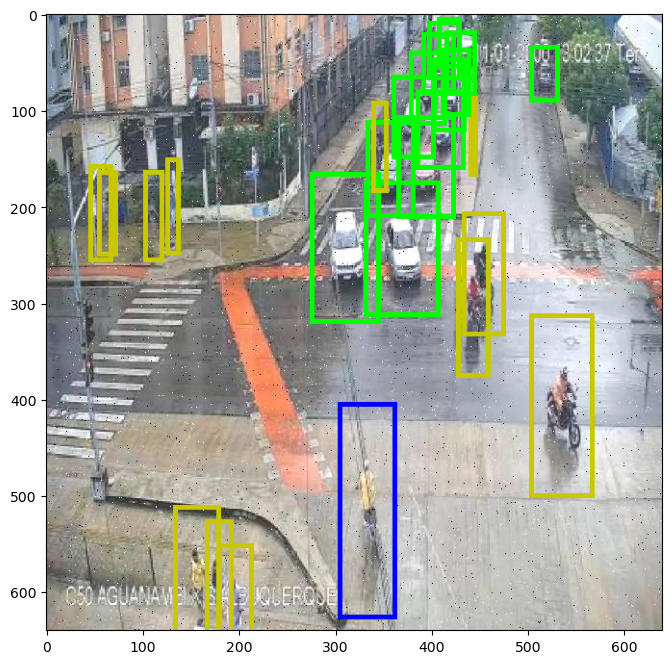

In [69]:
# Loading data
image_index = 5
images = os.listdir(f'{train_folder}/images')
labels = os.listdir(f'{train_folder}/labels')
image = plt.imread(f'{train_folder}/images/{images[image_index]}')
label = ''
object_coordinates = []
with open(f'{train_folder}/labels/{labels[image_index]}', 'r') as file:
    label = file.readlines()
new_image = image.copy()
for lab in label:
    coordinates = [float(num) for num in lab.split(' ')]
    new_image, coords = draw_boundary(new_image, colors[int(coordinates[0])], coordinates, False)
    object_coordinates.append(coords)

print(labels[image_index], images[image_index])

plt.figure(figsize=(8, 8))
plt.imshow(new_image)

In [70]:
def resize_region(image, x, y, width, height, new_size = (64, 64)):
    cropped_image = image[x - width: x + width, y - height : y + height, :]
    cropped_image = cv2.resize(cropped_image, new_size)
    return cropped_image

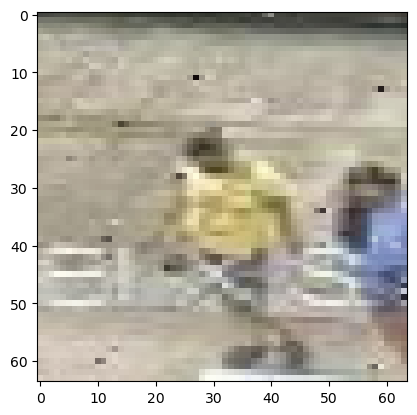

In [71]:
cropped_image = resize_region(image, object_coordinates[0][1], object_coordinates[0][2], object_coordinates[0][3], object_coordinates[0][4])
plt.imshow(cropped_image)

# Data Generator

In [87]:
class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, batch_size, shuffle=True):
        self.folder = folder
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.images = os.listdir(f'{folder}/images')
        self.labels = os.listdir(f'{folder}/labels')
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.images, self.labels = shuffle(self.images, self.labels)

    def __len__(self):
        return int(len(self.images) / self.batch_size)

    def __getitem__(self, index):
        i = index
        X = []
        region_ratios = [[1, 1], [2, 1]]
        region_scales = [16, 32, 48, 64]
        while i < len(self.images) - self.batch_size and len(X) == 0:
            batch_images = self.images[i * self.batch_size:(i + 1) * self.batch_size]
            batch_labels = self.labels[i * self.batch_size:(i + 1) * self.batch_size]
            X = []
            y = []
            # y2 = []
            for j in range(self.batch_size):
                image, object_coordinates = load_image(self.folder, batch_images, batch_labels, j)
                if len(object_coordinates) == 0:
                    continue
                regions = propose_train_regions(image, object_coordinates, 20, region_ratios, region_scales)
                for object_coords in regions:
                    if not is_region_inside_image(image, object_coords[1], object_coords[2], object_coords[3], object_coords[4]):
                        continue

                    cropped_image = resize_region(image, object_coords[1], object_coords[2], object_coords[3], object_coords[4], (128, 128))
                    X.append(cropped_image)
                    y.append(int(object_coords[0]))
                    # y2.append(object_coords[1:])

            X = np.asarray(X).astype('float32')
            X = X / 255.
            y = np.array(y, dtype='int32')
            # y = {
            #     'classifier': np.array(y1, dtype='int32'),
            #     'boundary_definer': np.array(y2, dtype='float32')
            # }
            i += 1
        return X, y

In [88]:
train_generator = ImageGenerator(train_folder, 1, True)
valid_generator = ImageGenerator(valid_folder, 2)
test_generator = ImageGenerator(test_folder, 2)
for x, y in train_generator:
    print(y.shape)
    break

(15,)


# Defining & Training Model

In [89]:
i = Input(shape=(128, 128, 3))
x = Conv2D(32, (3,3), activation='relu')(i)
x = MaxPooling2D(2, 2)(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=32, activation='relu')(x)
out = Dense(units=len(classes), activation='softmax', name='classifier')(x)
model = Model(i, out)
model.compile(loss={'classifier': 'sparse_categorical_crossentropy'}, optimizer='adam', metrics={'classifier': 'accuracy'})
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 30, 32)       0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 28800)             0   

In [91]:
history = model.fit(train_generator, epochs=10, steps_per_epoch=100, validation_data=valid_generator, validation_steps=20)

Epoch 1/10
100/100 [==============================] - 4s 41ms/step - loss: 0.7016 - accuracy: 0.7114 - val_loss: 0.5828 - val_accuracy: 0.7016
Epoch 2/10
100/100 [==============================] - 4s 42ms/step - loss: 0.8065 - accuracy: 0.6987 - val_loss: 0.5654 - val_accuracy: 0.7805
Epoch 3/10
100/100 [==============================] - 6s 62ms/step - loss: 0.6709 - accuracy: 0.7508 - val_loss: 0.6589 - val_accuracy: 0.6968
Epoch 4/10
100/100 [==============================] - 4s 36ms/step - loss: 0.6842 - accuracy: 0.7078 - val_loss: 0.4693 - val_accuracy: 0.8315
Epoch 5/10
100/100 [==============================] - 3s 33ms/step - loss: 0.6405 - accuracy: 0.7412 - val_loss: 0.5566 - val_accuracy: 0.7975
Epoch 6/10
100/100 [==============================] - 3s 31ms/step - loss: 0.5653 - accuracy: 0.7796 - val_loss: 0.6020 - val_accuracy: 0.7609
Epoch 7/10
100/100 [==============================] - 3s 33ms/step - loss: 0.5490 - accuracy: 0.7979 - val_loss: 0.6191 - val_accuracy: 0.7904

In [92]:
model.evaluate(test_generator)

139/139 [==============================] - 4s 29ms/step - loss: 0.4873 - accuracy: 0.8192


[0.48727652430534363, 0.8192488551139832]

In [93]:
# Saving the model
model.save('classification_network.h5')

Text(0, 0.5, 'Loss')

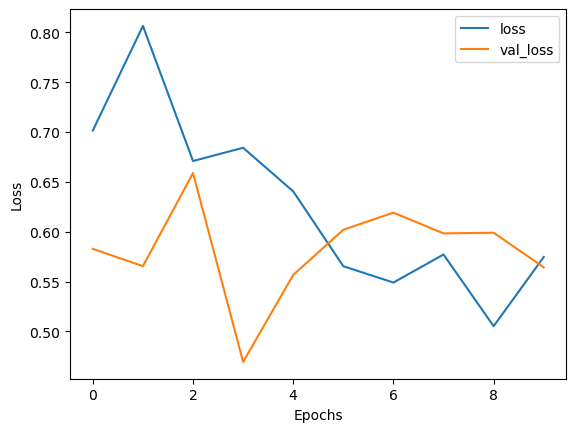

In [94]:
# Plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss', 'classifier_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

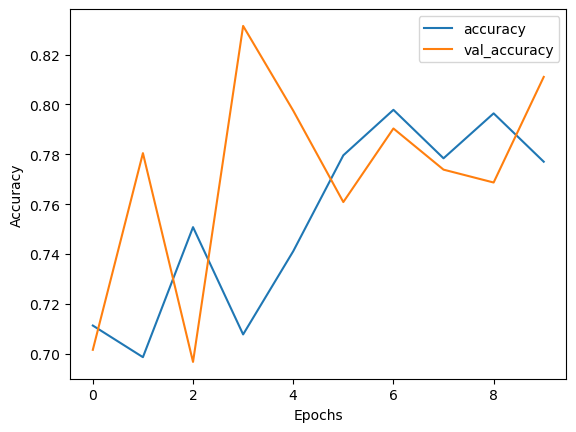

In [95]:
# Plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['classifier_accuracy'])
# plt.plot(history.history['boundary_definer_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

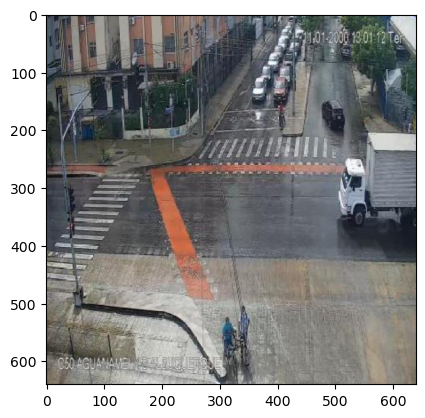

In [96]:
test_images = os.listdir(f'{test_folder}/images')
test_labels = os.listdir(f'{test_folder}/labels')
test_image, test_objects_coords = load_image(test_folder, test_images, test_labels, 0)
object_index = 2
upscaled_coords = test_objects_coords[object_index]
modified_image = test_image.copy()
modified_image, coords = draw_boundary(modified_image, [255, 0, 0], test_objects_coords[object_index], False)
plt.imshow(modified_image)

(1, 128, 128, 3)


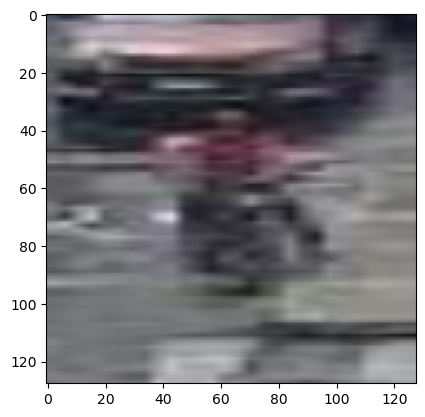

In [97]:
test_cropped_image = resize_region(test_image, upscaled_coords[1], upscaled_coords[2], upscaled_coords[3], upscaled_coords[4], (128, 128))
plt.imshow(test_cropped_image)
test_cropped_image = np.reshape(test_cropped_image, (1, 128, 128, 3))
print(test_cropped_image.shape)

In [98]:
predictions = model.predict(test_cropped_image)

1/1 [==============================] - 0s 75ms/step


bicycle


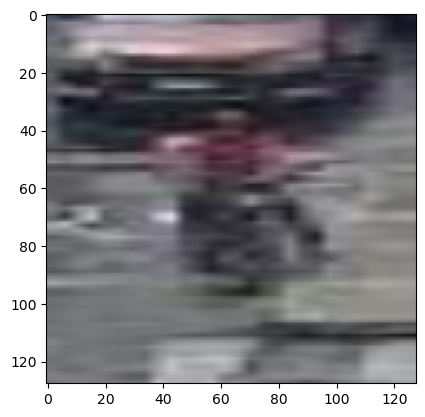

In [101]:
predicted_class = np.argmax(predictions)
print(classes[predicted_class])
plt.imshow(test_cropped_image[0])

# Combining both models for final Result

In [33]:
x = np.array([[0, 1, 2], [4, 5, 6], [7, 8, 9], [0, 2, 4]])
y = np.array([0.4, 0.7, 0.6,0.8])
y = np.reshape(y, (-1, 1))
print(y.shape)
y = np.reshape(y, (-1,))
y.shape

(4, 1)


(4,)

In [102]:
rpn = load_model('region_proposal_network.h5')
classifier = load_model('classification_network.h5')

In [103]:
def detect_objects(image, rpn, classifier, region_ratios, region_scales):
    anchor_point_stride = 15
    anchor_points = generate_anchor_points(image, anchor_point_stride)
    regions = generate_regions(anchor_points, region_ratios, region_scales)
    print(f'Anchor Points: {len(anchor_points)} - Regions: {len(regions)}')
    final_regions = []
    region_images = []
    for region in regions:
        if not is_region_inside_image(image, region[0], region[1], region[2], region[3]):
            continue

        final_regions.append(region)
        region_images.append(resize_region(image, region[0], region[1], region[2], region[3], (128, 128)))
    
    final_regions = np.array(final_regions)
    region_images = np.array(region_images)
    region_proposals = rpn.predict(region_images)
    region_cofidence = 0.7
    region_proposals = np.reshape(region_proposals, (-1,))
    target_regions = final_regions[region_proposals > region_cofidence]
    print(f'Proposed Regions: {len(target_regions)} out of {len(final_regions)}')
    target_region_images = region_images[region_proposals > region_cofidence]
    predicted_classes = classifier.predict(target_region_images)
    proposed_regions = []
    predicted_classes = np.argmax(predicted_classes, axis= 1)
    proposed_region_classes = []
    # Performing non-maximum suppression
    for i in range(len(target_regions)):
        has_overlapping_region = False
        for j in range(i + 1, len(target_regions)):
            r1 = target_regions[i]
            r2 = target_regions[j][:]
            r2 = np.insert(r2, 0, 0)
            iou = find_IOU(r2, r1)
            if iou > 0.2:
                has_overlapping_region = True
                break
        if not has_overlapping_region:
            proposed_regions.append(r1)
            proposed_region_classes.append(predicted_classes[i])
    print(f'Final Regions: {len(proposed_regions)}')
    return proposed_regions, proposed_region_classes

In [104]:
for class_name, color in zip(classes, colors):
    print(f'{class_name} -> {color}')

bicycle -> [0, 0, 255]
bus -> [255, 0, 0]
car -> [0, 255, 0]
motorbike -> [200, 200, 0]
person -> [200, 200, 200]


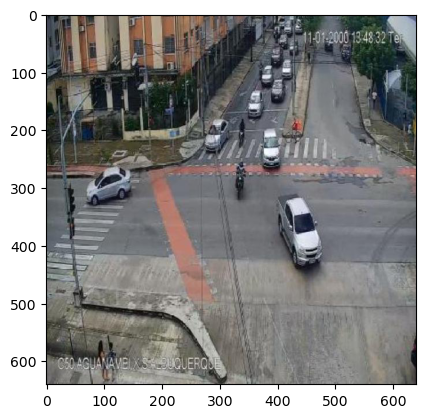

In [108]:
img_index = 22
image, object_coords = load_image(test_folder, test_images, test_labels, img_index)
plt.imshow(image)

In [109]:
region_ratios = [[1, 1], [2, 1]]
region_scales = [16, 32, 48, 64]
detected_regions, detected_classes = detect_objects(image, rpn, classifier, region_ratios, region_scales)

Anchor Points: 1764 - Regions: 14112
321/321 [==============================] - 2s 5ms/step
Proposed Regions: 81 out of 10272
3/3 [==============================] - 0s 9ms/step
Final Regions: 10


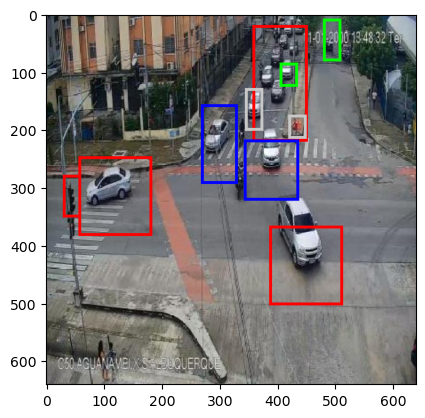

In [110]:
copied_image = image.copy()
for region, region_class in zip(detected_regions, detected_classes):
    copied_image = draw_boundary(copied_image, colors[region_class], region, True, False)
plt.imshow(copied_image)

Text(0.5, 1.0, 'Predicted Class: car')

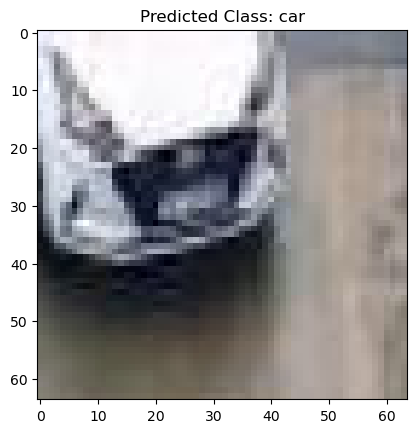

In [157]:
region_index = 19
selected_region = detected_regions[region_index]
resized_image =  resize_region(image, selected_region[0], selected_region[1], selected_region[2], selected_region[3])
plt.imshow(resized_image)
plt.title(f'Predicted Class: {classes[detected_classes[region_index]]}')